In [1]:
import tensorflow as tf
from tensorflow.keras import Model
import nodepy.linear_multistep_method as lm

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import timeit

# 1. 2-D Harmonic Oscillator

As a benchmark problem, the 2-D Cubic Harmonic Oscillator:

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$.

In [ ]:
def f_cubic(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

Now we are ready to create the training dataset by integrating the above system of equations to obtain the measurements. We also introduce a Gaussian noise to the dataset.

In [ ]:
# create time points
time_points = np.arange(0,25,0.01)

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

In [ ]:
# create training data

noise = 0.00 #strength of the noise

skip = 1
dt = time_points[skip] - time_points[0]
X_train = simulated_x[0::skip,:]
X_train = X_train + noise * X_train.std(0) * np.random.randn(X_train.shape[0], X_train.shape[1])

X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))

# 2. 2-D Yeast Glycolytic Oscillator

The system of equations for this system is described in the notebook `Analysis - Data Exploration and Visualization`. Here we simulate the dataset and transform it into tensor for training.

In [2]:
def bier(x,t, params=None):
    """
    2-D Yeast Glycolytic oscillator model
    
    Args:
        x -- a 2 x 1 vector of measurements
        t -- time, ignored
        
    Return:
        A numpy array containing the derivatives
    """
    if params == None:
        # default parameter values
        Vin = 0.36
        k1 = 0.02
        kp = 6
        km = 12
    else:
        Vin = params['Vin']
        k1 = params['k1']
        kp = params['kp']
        km = params['km']
    
    r1 = 2 * k1 * x[0] * x[1] - kp * x[0]/(x[0] + km) # ATP
    r2 = Vin - k1 * x[0] * x[1] #G
    
    return np.ravel(np.array([r1, r2]))

In [3]:
# specify the settings for the bier data

t0, T, h = 0, 500, 0.2 #seconds
x0 = np.array([4, 3]) #initial conditions: ATP = 4, G = 3 -- default Bier model
params = {'Vin': 0.36, 'k1': 0.02, 'kp':4, 'km':15} # damped oscillation
f_bier = lambda x, t: bier(x, t, params)

In [4]:
def create_training_data(array):
    """
    Create tensor array for training
    """
    
    training_data = np.reshape(array, (1,array.shape[0], array.shape[1]))
    
    return tf.convert_to_tensor(training_data, dtype=tf.float32)

In [5]:
# generate bier data by solving the ODE
time_points = np.arange(t0, T, h)
bier_data = odeint(f_bier, x0, time_points)
bier_data = create_training_data(bier_data)

# 3. Train the Multistep Neural Network

Define the Multistep Neural Network in TensorFlow and train it on the 2-D Bier data. We investigate the performance of the Multistep Neural Network for different number of steps and LMM schemes.

In [6]:
tf.keras.backend.set_floatx('float32')

class lmmNet:
    """
    Implementation of the LMMNet
    version 1.2
    Fixes/updates:
        * number of hidden layer units is no longer hardcoded
        * fixed bug for wrong indexing of the coefficients in computing linear diff operator
        * loss printed every 100 epochs
        * optimizer now declared in constructor

    """
    
    def __init__(self, h, X, M, scheme, hidden_units):
        """
        Args:
        h -- step size
        X -- data array with shape S x N x D 
        M -- number of LMM steps
        scheme -- the LMM scheme (either AB, AM, or BDF)
        hidden_units -- number of units for the hidden layer
        
        """
        self.h = h
        self.X = X
        self.M = M # number of time steps
        
        # get the number of trajectories, discrete time instances, and number of feature dimensions
        self.S = X.shape[0]
        self.N = X.shape[1]
        self.D = X.shape[2]
        
        # load LMM coefficients from NodePy
        # https://nodepy.readthedocs.io/en/latest/
        if scheme == 'AB':
            coefs = lm.Adams_Bashforth(M)
        elif scheme == 'AM':
            coefs = lm.Adams_Moulton(M)
        elif scheme == 'BDF':
            coefs = lm.backward_difference_formula(M)
        else:
            raise Exception('Please choose a valid LMM scheme')
        
        self.alpha = np.float32(-coefs.alpha[::-1])
        self.beta = np.float32(coefs.beta[::-1])
        
        class DenseModel(Model):
            """
            A simple feed-forward network with 1 hidden layer
            
            Arch:
            * 256 hidden units
            * input units and output units correspond to the dimensionality
            """
            def __init__(self, D):
                super(DenseModel, self).__init__()
                self.D = D

                self.d1 = tf.keras.layers.Dense(units=hidden_units, activation=tf.nn.tanh, input_shape=(self.D,))
                self.d2 = tf.keras.layers.Dense(units=self.D, activation=None)

            def call(self, X1):
                A = self.d1(X1)
                A = self.d2(A)
                return A
        
        self.nn = DenseModel(self.D)
                
        self.opt = tf.keras.optimizers.Adam()
        
    def get_F(self, X):
        """
        Output of the NN/ML model.
        
        Args:
        - X: the data matrix with shape S x (N-M) x D
        
        Output:
        - F: the output dynamics with shape S x (N-M) x D
        """

        assert X.shape == (self.S, self.N - self.M, self.D)
        
        X1 = tf.reshape(X, [-1, self.D])
        F1 = self.nn(X1)
        
        return tf.reshape(F1, [self.S, -1, self.D])
    
    def get_Y(self, X):
        """
        The linear difference (residual) operator.
        
        Args:
        - X: the data matrix with shape S x N x D
        """
        
        M = self.M
        
        # compute the difference operator
        # broadcasting from M to N to get an array for all n
        # Y has shape S x (N - M) x D
        Y = self.alpha[0] * X[:, M: ,:] + self.h * self.beta[0] * self.get_F(X[:, M:, :]) # for m = 0
        
        # sum over m from m = 1
        for m in range(1, M+1):
            Y += self.alpha[m] * X[:, M-m:-m, :] + self.h * self.beta[m] * self.get_F(X[:, M-m:-m, :])
        
        return self.D * tf.reduce_mean(tf.square(Y))
    
    def train(self, epochs):
        """
        Fit the model PyTorch-style
        """
        
        start_time = timeit.default_timer()
        
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                self.loss = self.get_Y(self.X)
            grads = tape.gradient(self.loss, self.nn.trainable_variables)
            self.opt.apply_gradients(zip(grads, self.nn.trainable_variables))
            
            if epoch % 100 == 0:
                elapsed_time = timeit.default_timer() - start_time
                #print('Epoch: %d, Time: %.2f, Loss: %.4e' %(epoch, elapsed_time, self.loss))
                #tf.print(self.loss)

        
    def predict(self, X_reshaped):
        """
        Args:
        - X_reshaped with shape S(N-M+1) x D
        """
        return self.nn(X_reshaped)

In [7]:
def ml_f(x, t, model):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    I think this is the best implementation (more robust than flatten())
    """
    return np.ravel(model.predict(x.reshape(1,-1)))

In [8]:
# train LMM with different schemes and number of steps
M_list = [1, 2, 3, 4, 5]
scheme_list = ['AM', 'AB', 'BDF']

# for storing results
result_dict = {}
result_dict['data'] = bier_data
result_dict['t'] = time_points

for scheme in scheme_list:
    for M in M_list:
        print('Training MultistepNet for M = ', M, 'on family = ', scheme)
        model = lmmNet(h, bier_data, M, scheme, hidden_units=256)
        model.train(10000)
        
        pred = odeint(ml_f, x0, time_points, args=(model,))
        
        # store the result
        result_dict[scheme + str(M) + 'pred'] = pred
        result_dict[scheme + str(M) + 'f'] = [ml_f(x, None, model) for x in np.squeeze(bier_data)]

Training MultistepNet for M =  1 on family =  AM

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Training MultistepNet for M =  2 on family =  AM

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you 

Training MultistepNet for M =  2 on family =  BDF

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Training MultistepNet for M =  3 on family =  BDF

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, yo

In [9]:
import pickle

# save result to file (important!)
with open('benchmark_bier_cubic.pkl', 'wb') as file:
        pickle.dump(result_dict, file)

# 4. Results

The performance on 2-D Harmonic oscillator is taken from [MultiStep Neural Network](https://maziarraissi.github.io/research/7_multistep_neural_networks/).

In [10]:
# first component MSE
harmonic1_ab = [1.5, 0.031, 0.12, 0.043, 0.012]
harmonic1_am = [0.0088, 0.012, 0.016, 0.0063, 0.011]
harmonic1_bdf = [1.3, 0.0088, 0.013, 0.014, 0.017]

# second component MSE
harmonic2_ab = [1.5, 0.03, 0.097, 0.035, 0.012]
harmonic2_am = [0.0083, 0.01, 0.016, 0.0058, 0.011]
harmonic2_bdf = [1.3, 0.0086, 0.0099, 0.014, 0.015]

In [27]:
def compute_MSE(pred, data, index):
    pred_array = np.array(pred)
    data = np.squeeze(data)
    return np.linalg.norm(data[:,index] - pred_array[:,index], 2)/np.linalg.norm(data[:,index], 2)

Next we compute the MSE from the 2-D Yeast Glycolytic Oscillator results.

In [28]:
# first component
glycolytic1_ab = [compute_MSE(result_dict['AB'+str(i)+'pred'], bier_data, 0) for i in range(1, 6)]
glycolytic1_am = [compute_MSE(result_dict['AM'+str(i)+'pred'], bier_data, 0) for i in range(1, 6)]
glycolytic1_bdf = [compute_MSE(result_dict['BDF'+str(i)+'pred'], bier_data, 0) for i in range(1, 6)]

# second component
glycolytic2_ab = [compute_MSE(result_dict['AB'+str(i)+'pred'], bier_data, 1) for i in range(1, 6)]
glycolytic2_am = [compute_MSE(result_dict['AM'+str(i)+'pred'], bier_data, 1) for i in range(1, 6)]
glycolytic2_bdf = [compute_MSE(result_dict['BDF'+str(i)+'pred'], bier_data, 1) for i in range(1, 6)]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


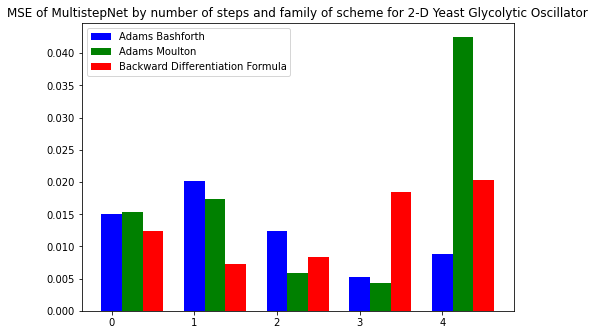

In [44]:
data = [glycolytic1_ab, glycolytic1_am, glycolytic1_bdf]
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MSE of MultistepNet by number of steps and family of scheme for 2-D Yeast Glycolytic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])

plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


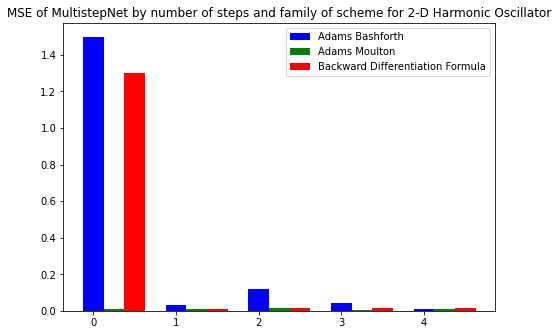

In [43]:
data = [harmonic1_ab, harmonic1_am, harmonic1_bdf]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MSE of MultistepNet by number of steps and family of scheme for 2-D Harmonic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])
plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


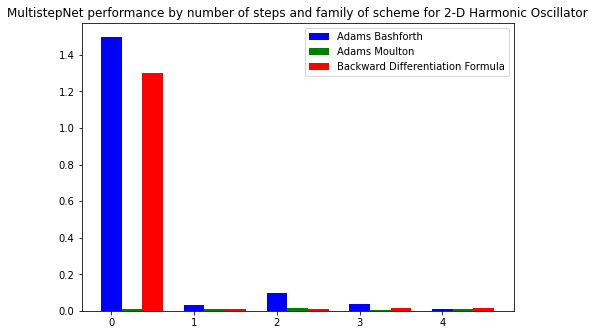

In [41]:
data = [harmonic2_ab, harmonic2_am, harmonic2_bdf]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MultistepNet performance by number of steps and family of scheme for 2-D Harmonic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])
plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


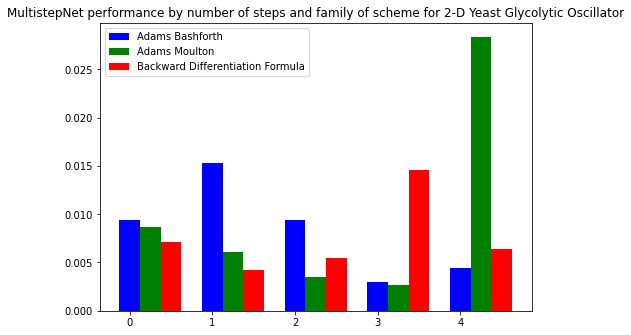

In [42]:
data = [glycolytic2_ab, glycolytic2_am, glycolytic2_bdf]
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MultistepNet performance by number of steps and family of scheme for 2-D Yeast Glycolytic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])

plt.show()

Text(0.5, 1.0, 'Trajectories of 2D Yeast Glycolytic Oscillator')

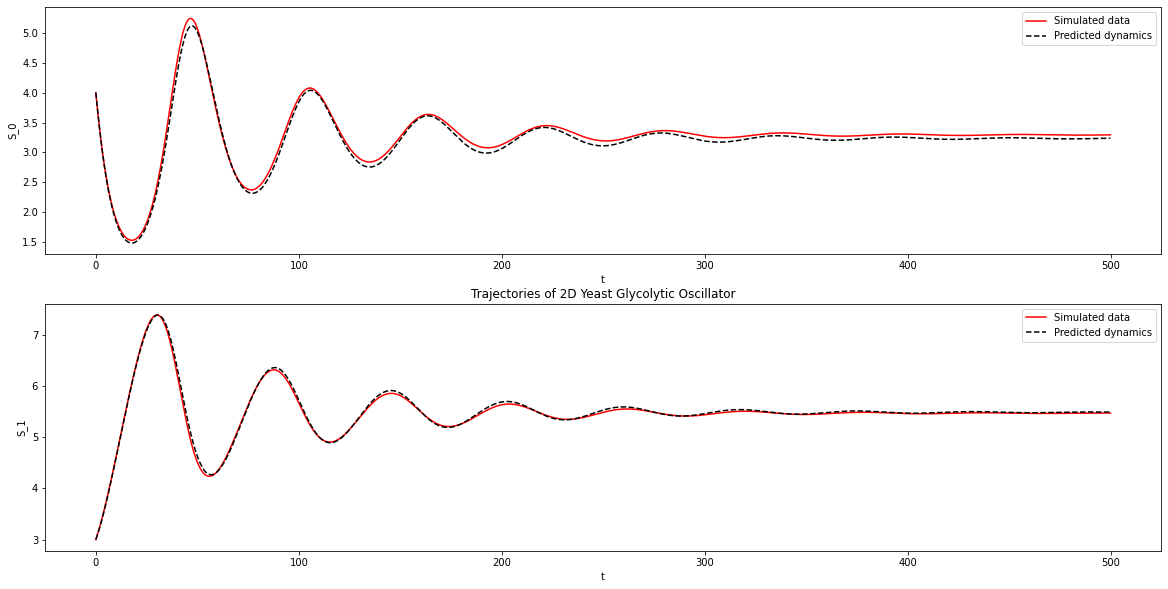

In [50]:
bier_data = np.squeeze(bier_data)
plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolytic Oscillator')

Text(0.5, 1.0, 'Phase plane of 2D Yeast Glycolytic Oscillator')

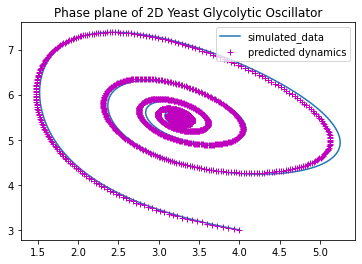

In [51]:
# Phase plane

plt.plot(bier_data[:,0], bier_data[:,1], label='simulated_data')
plt.legend()
plt.plot(pred[:,0], pred[:,1], 'm+', label='predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Yeast Glycolytic Oscillator')